## Load Libraries

In [15]:
import torch
from torchvision import transforms
import torchvision.models as models
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, Subset, SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.decomposition import PCA

# roc_curve and average precision score requires the predicted probability instead of predicted label as input
from sklearn.metrics import accuracy_score, roc_curve, auc, average_precision_score, recall_score, f1_score, precision_score

from PIL import Image
import tqdm.notebook as tqdm
import copy

## Inpiration for the classifier
https://machinelearningmastery.com/building-a-binary-classification-model-in-pytorch/ 

## Linear Classfier

In [16]:
# Define model
class Linear_NN(torch.nn.Module):

    # 180 is given from the one-hot encoding of the 20 amino acids * 9 peptide length
    def __init__(self, input_size):
        super(Linear_NN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, input_size // 2)
        self.fc2 = torch.nn.Linear(input_size//2, input_size // 10)
        self.fc3 = torch.nn.Linear(input_size//10, 1) 
        self.drop = torch.nn.Dropout(p=0.5)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.drop(x)
        out = self.fc3(x)
        out = self.sigmoid(out)
        return out

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Recurrent Neural Network

In [17]:
class RNN(torch.nn.Module):
    def __init__(self, input_size):
        super(RNN, self).__init__()
        
        # Define the RNN layer
        # Batch first means that the input and output tensors are provided as (batch, seq, feature)
        # num_layers is the number of stacked RNN layers
        self.rnn = torch.nn.RNN(input_size, hidden_size = 64, num_layers = 2, batch_first=True, nonlinearity='relu')
        
        # Define the fully connected layer
        self.fc = torch.nn.Linear(64, 1)

        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):

        h0 = torch.zeros(2, x.size(0), 64).to(device)

        # Forward pass
        out, _ = self.rnn(x, h0)
        # Output shape = (batch_size, seq_length, hidden_size)
        # -1 means the last element of the sequence
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        
        return out

## Load Peptides

In [18]:
peptide_score_file = './data/HLA_B_4002.txt'

def load_peptide_data(infile):

    peptides = list()
    labels = list()

    with open(infile) as f:
        for line in f:
            peptide, score = line.strip().split()
            peptides.append(list(peptide))
            labels.append(float(score))

    return peptides, labels

peptides, labels = load_peptide_data(peptide_score_file)

## One-Hot encoding 

In [19]:
def one_hot_encode_peptides(peptides, flatten = True):

    flattened_peptides = np.array(peptides).flatten().reshape(-1, 1)

    # Initialize the OneHotEncoder
    encoder = OneHotEncoder(categories=[list('ACDEFGHIKLMNPQRSTVWY')], sparse_output=False)

    # Transform the peptide sequences into a one-hot encoded format
    one_hot_encoded = encoder.fit_transform(flattened_peptides)

    
    num_peptides = len(peptides)
    
    if flatten:
        # Reshape back into the original peptide sequence format
        one_hot_encoded = one_hot_encoded.reshape(num_peptides, -1)
        
        return one_hot_encoded

    one_hot_encoded = one_hot_encoded.reshape(num_peptides, len(peptides[0]), -1)

    return one_hot_encoded

## PCA-reduced Pixel encoding

In [20]:
amino_acid_full_names = {
    'A': 'alanine', 'R': 'arginine', 'N': 'asparagine', 'D': 'aspartic_acid', 'C': 'cysteine', 
    'E': 'glutamic_acid', 'Q': 'glutamine', 'G': 'glycine', 'H': 'histidine', 'I': 'isoleucine', 
    'L': 'leucine', 'K': 'lysine', 'M': 'methionine', 'F': 'phenylalanine', 'P': 'proline',
    'S': 'serine', 'T': 'threonine', 'W': 'tryptophan', 'Y': 'tyrosine', 'V': 'valine'
}

### Load amino acid depictions

In [21]:
#store images in cache to save performance
image_cache = {}

def load_AA_image(img_path, vgg = True):

    if img_path in image_cache:
        return image_cache[img_path]
    
    # Define transformation to do on image
    
    # Maybe not do it, if vgg is not the method
    if vgg:
        transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        transform = transforms.Compose([transforms.ToTensor()])

    image = Image.open(img_path).convert('RGB')
    processed_image = transform(image).unsqueeze(0).to(device)
    
    image_cache[img_path] = processed_image
    
    return processed_image

In [22]:
def PCA_pixel_features(amino_acid_full_names, reduce_dim = True):
    
    pixel_features = []

    for letter, aa in amino_acid_full_names.items():
        # load and preprocess
        img_path = f'./2Dstruc/{aa}.png'
        image = load_AA_image(img_path, vgg = False)
        pixel_features.append(image.flatten())

    pixel_features = np.vstack(pixel_features)

    if reduce_dim:

        # PCA
        pca = PCA(random_state=42)
        pixel_features = pca.fit_transform(pixel_features)

        aa_features_dict = {}
        for idx, aa in enumerate(amino_acid_full_names.keys()):
            aa_features_dict[aa] = pixel_features[idx, :]

        return aa_features_dict, pca
    

    # Create dictionary with aa_name:PCA_feature
    aa_features_dict = {}
    for idx, aa in enumerate(amino_acid_full_names.keys()):
        aa_features_dict[aa] = pixel_features[idx, :]

    return aa_features_dict

## Plot PCA Variance

In [23]:
def plot_PCA_variance(pca, encoding_method, cumulative=True):
    # Assuming you have already performed PCA and stored it in the variable 'pca'
    variance_ratio = pca.explained_variance_ratio_

    if cumulative:
        cumulative_variance = np.cumsum(variance_ratio)
        plt.figure()
        plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, '*-')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Variance')
        plt.title('Cumulative Variance by Number of Components, Encoding Method: ' + encoding_method)
        plt.show()
    else:
        plt.figure()
        plt.bar(range(1, len(variance_ratio)+1), variance_ratio)
        plt.xlabel('Number of Components')
        plt.ylabel('Variance Ratio')
        plt.title('Variance Ratio by Number of Components, Encoding Method: ' + encoding_method)
        plt.show()
    

## VGG Features

In [24]:
def load_image(img_path):
    img = Image.open(img_path)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
    ])

    img_tensor = transform(img)

    return img_tensor

In [27]:
def vgg_features(amino_acid_full_names, reduce_dim = True):

    # Define VGG model
    vgg16_bn = torch.nn.Sequential(   
    # Use only the convolutionary part
    models.vgg16_bn(pretrained = True).features,
    torch.nn.Flatten()
    )

    vgg16 = vgg16_bn.to(device)
    vgg16.eval()

    vgg_features = []

    for aa in amino_acid_full_names.values():
        # load and preprocess
        img_path = f'./2Dstruc/{aa}.png'
        image = load_AA_image(img_path)

        # Disable gradient calculation
        with torch.no_grad():
            conv_features = vgg16(image)

        vgg_features.append(conv_features.cpu().numpy())

    vgg_features = np.vstack(vgg_features)

    if reduce_dim:

        pca = PCA(random_state=42)
        vgg_features = pca.fit_transform(vgg_features)
        
        aa_features_dict = {}
        for idx, aa in enumerate(amino_acid_full_names.keys()):
            aa_features_dict[aa] = vgg_features[idx, :]

        return aa_features_dict, pca

    # Create dictionary with aa_name:PCA_feature
    aa_features_dict = {}
    for idx, aa in enumerate(amino_acid_full_names.keys()):
        aa_features_dict[aa] = vgg_features[idx, :]

    return aa_features_dict

: 

## ResNet50

In [131]:
def resnet50_feature_extractor(amino_acid_full_names):
    resnet50 = models.resnet50(pretrained=True)
    feature_extractor = torch.nn.Sequential(*list(resnet50.children())[:-1]).to(device)

    feature_extractor.eval()
    
    resnet50_features = {}

    for letter, aa in amino_acid_full_names.items():
        # load and preprocess
        img_path = f'./2Dstruc/{aa}.png'
        image = load_AA_image(img_path)
        with torch.no_grad():
            feature = feature_extractor(image)
            resnet50_features[letter] = feature.cpu().numpy().flatten()
    
    return resnet50_features

## Peptide Encoding

In [13]:
def Encoder(peptides, aa_features_dict, flatten = True):
    
    encoded_peptides = []

    for peptide in peptides:
        encoded_peptide = []
    
        for aa in peptide:
            encoded_peptide.append(aa_features_dict[aa])
        
        if flatten:
            encoded_peptide = np.array(encoded_peptide).flatten()
        
        encoded_peptides.append(encoded_peptide)

    return np.array(encoded_peptides)

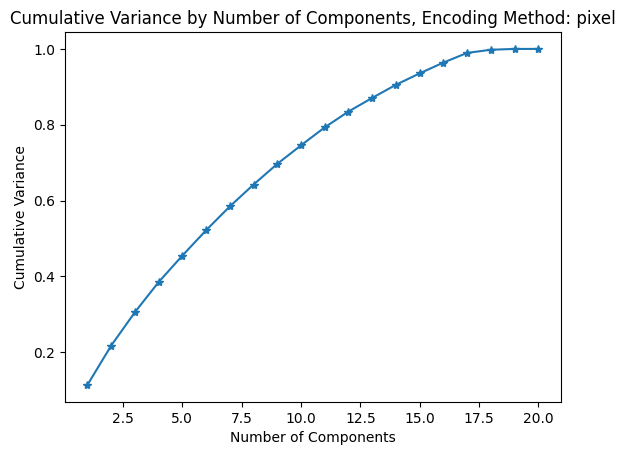

Input size to the network: 20


In [133]:
encoding_method = 'pixel' # onehot, pixel, vgg, resnet50
network_type = 'rnn' # linear, rnn
reduce_dim = True

# If input need to be flattened
if network_type == 'linear':
    flatten = True
else:
    flatten = False


# Encode method
if encoding_method == 'onehot':
    encoded_peptides = one_hot_encode_peptides(peptides, flatten=flatten)

elif encoding_method == 'pixel':
    if reduce_dim:
        aa_feature_dict, pca = PCA_pixel_features(amino_acid_full_names, reduce_dim=reduce_dim)
    else:
        aa_feature_dict = PCA_pixel_features(amino_acid_full_names, reduce_dim=reduce_dim)
    
    encoded_peptides = Encoder(peptides, aa_feature_dict, flatten=flatten)

elif encoding_method == 'vgg':
    if reduce_dim:
        aa_feature_dict, pca = vgg_features(amino_acid_full_names, reduce_dim=reduce_dim)
    else:   
        aa_feature_dict = vgg_features(amino_acid_full_names, reduce_dim=reduce_dim)
    
    encoded_peptides = Encoder(peptides, aa_feature_dict, flatten=flatten)

elif encoding_method == 'resnet50':
    aa_feature_dict = resnet50_feature_extractor(amino_acid_full_names)
    encoded_peptides = Encoder(peptides, aa_feature_dict, flatten=flatten)

# If PCA is applied
if reduce_dim and encoding_method != 'onehot':
    plot_PCA_variance(pca, encoding_method, cumulative=True)
  
if network_type == 'linear':
    input_size = encoded_peptides[0].shape[0]
else:
    input_size = encoded_peptides[0].shape[1]

print(f'Input size to the network: {input_size}')

## Training Network

### Define function to reset weight
Reset weight to prevent bias

In [134]:
def reset_weights(m):
    if hasattr(m, 'reset_parameters'):
        print(f'reset weight of layer {m}')
        m.reset_parameters()

### Training using 5-fold cross validation

In [135]:
peptides_tensor = torch.tensor(encoded_peptides, dtype=torch.float32).to(device)
labels_tensor = torch.tensor(np.asarray(labels).reshape(-1,1), dtype=torch.float32).to(device)

peptides_dataset = TensorDataset(peptides_tensor, labels_tensor)

In [136]:
def plot_loss(train_loss, val_loss, val_acc, fold):
    
    fig, ax = plt.subplots(3, 1, figsize=(10, 10))

    for i, ytitle in enumerate(['loss', ['log loss']]):
        ax[i].plot(train_loss, label='train loss', linestyle='-.')
        ax[i].plot(val_loss, label='val loss', linestyle='-.')
        ax[i].set_xlabel('Epoch')
        ax[i].set_ylabel(ytitle)
        ax[i].legend()
    ax[1].set_yscale('log')

    ax[2].plot(val_acc, label='val acc',  linestyle='-.')
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('Accuracy')
    ax[2].legend()

    plt.savefig(f'./loss/{network_type}/{encoding_method}_loss_fold_{fold}.png')
    plt.close()
    

In [137]:
def model_train(model, X_train, y_train, X_val, y_val, fold):

    # loss function and optimizer
    loss_fn = torch.nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 100   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    train_loss = []
    val_loss = []
    val_acc = []

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0

        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True, leave = False) as bar:
            bar.set_description(f"Epoch {epoch+1}")
            
            for start in bar:

                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                
                epoch_loss += loss.item()

                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        
        train_loss.append(epoch_loss/len(batch_start))

        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        epoch_val_loss = loss_fn(y_pred, y_val).item()
        acc = accuracy_score(y_val.cpu().numpy(), y_pred.round().cpu().detach().numpy())
        
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        
        val_loss.append(epoch_val_loss)
        val_acc.append(acc)
    

    torch.save(best_weights, f'./model/{network_type}/{encoding_method}_model_fold_{fold}.pt')
    plot_loss(train_loss, val_loss, val_acc, fold)
    

    return best_acc

In [138]:
seed = 42
n_splits = 5

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(peptides_tensor, labels_tensor, train_size=0.7, shuffle=True, random_state=seed)


# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

cv_scores = []
for fold, (train, test) in enumerate(kfold.split(X_train, y_train), 1):
    # create model, train, and get accuracy
    
    if network_type == 'linear':
        model = Linear_NN(input_size)
    elif network_type == 'rnn':
        model = RNN(input_size)

    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], fold)
    print(f"Accuracy {fold}: %.5f" % acc)
    
    cv_scores.append(acc)
    

Accuracy 1: 0.94249
Accuracy 2: 0.95918
Accuracy 3: 0.93494
Accuracy 4: 0.93866
Accuracy 5: 0.94052


## Evaluating model

In [139]:
def plot_roc(y_true, y_pred, label=None):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.3f})')

In [140]:
def evaluate_ensembl(X_test, y_test, n_splits):  
    
    perf_f = open(f'./evaluation_result/performance/{network_type}/{encoding_method}_performance.txt', 'w')

    metrics = {
        'accuracy': accuracy_score,
        'average precision score': average_precision_score,
        'recall score': recall_score,
        'f1 score': f1_score
    }

    plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random', color = 'k')

    ensembl_predictions = []
    score_lists = {name: [] for name in metrics.keys()}


    for i in range(n_splits):
        
        if network_type == 'linear':
            model = Linear_NN(input_size)
        elif network_type == 'rnn':
            model = RNN(input_size)

        model.load_state_dict(torch.load(f'./model/{network_type}/{encoding_method}_model_fold_{i+1}.pt'))

        model.eval()
        with torch.no_grad():
            y_pred_prob = model(X_test).cpu()
            ensembl_predictions.append(y_pred_prob)
        
        # plot roc for each fold
        plot_roc(y_test.cpu(), y_pred_prob, label=f'Fold {i+1}')

        # scoring each fold using the metrics
        thereshold = 0.5
        y_pred = (y_pred_prob.numpy() > thereshold).astype(int)
        for name, scoring in metrics.items():
            score_lists[name].append(scoring(y_test.cpu(), y_pred))


    avg_ensembl_predictions = torch.stack(ensembl_predictions).mean(dim=0)

    # Print score for each fold
    print(f"{'-'*50}\nCross Validation\n{'-'*50}\n", file=perf_f)
    for name, scores in score_lists.items():
            mean_score = np.mean(scores)
            std_score = np.std(scores)
            print(f"{name}", file=perf_f)
            print(f"5-Fold Cross-Validation {name} scores: {np.round(scores, 3)}", file=perf_f)
            print(f"Mean {name} score: {mean_score:.3f} +/- {std_score:.3f}\n", file=perf_f)
    
    # Plot roc for ensembl
    plot_roc(y_test.cpu(), avg_ensembl_predictions.cpu(), label='Ensemble')
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right')
    plt.savefig(f'./evaluation_result/roc/{network_type}/{encoding_method}_roc.png')
    plt.close()

    # Calculate metrics scores for ensembl
    avg_ensembl_predictions = (avg_ensembl_predictions.round().numpy() > thereshold).astype(int)
    print(f"{'-'*50}\nEnsembl\n{'-'*50}\n", file=perf_f)
    for name, scoring in metrics.items():
        print(f"{name}", file=perf_f)
        print(f"Ensembl {name} score: {scoring(y_test.cpu(),avg_ensembl_predictions):.3f}\n", file=perf_f)

    perf_f.close()

    # Note
    # Change name of  ensembl_predictions to predictions and avg_e_prediction to ensembl_predictions
    ensembl_predictions = [predictions.round().numpy() for predictions in ensembl_predictions]


    # Save the prediction results
    pred_f = open(f'./evaluation_result/predictions/{network_type}/{encoding_method}_predictions.txt', 'w')
    y_test = y_test.numpy()
    print('ytest  fold_1  fold_2  fold_3  fold_4  fold_5  ensembl', file = pred_f)
    for i in range(len(y_test)):
        print(y_test[i], end = '\t', file = pred_f)
        
        for j in range(len(ensembl_predictions)):
            print(ensembl_predictions[j][i], end = '\t', file = pred_f)
        
        print(avg_ensembl_predictions[i], file = pred_f)
    pred_f.close()

              
evaluate_ensembl(X_test, y_test, n_splits)

: 